Minard Dataset Analysis with Girvan-Newman Community Detection

Unified Graph Statistics:
  Total nodes: 50
  Total edges: 47
  Network density: 0.0384

Label Distribution:
  Advance (1): 24 nodes (48.0%)
  Retreat (0): 26 nodes (52.0%)

Applying Girvan-Newman Algorithm...
  Communities found: 5
  Community sizes: [17, 9, 9, 9, 6]
  Modularity: 0.3536

✅ Graph exported to 'minard_girvan_newman.gexf' successfully!

✅ Graph exported to 'minard_girvan_newman.gexf' successfully!

Performance Metrics (Girvan-Newman Communities):
  Accuracy:  0.8400
  Precision: 0.7500
  Recall:    1.0000
  F1 Score:  0.8571
  AUC-ROC:   0.4367

Generating visualizations...


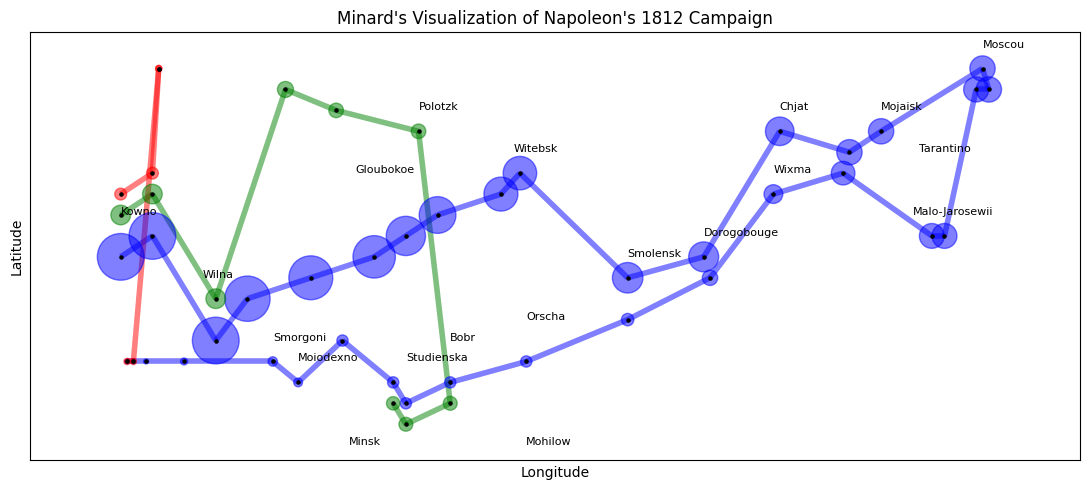

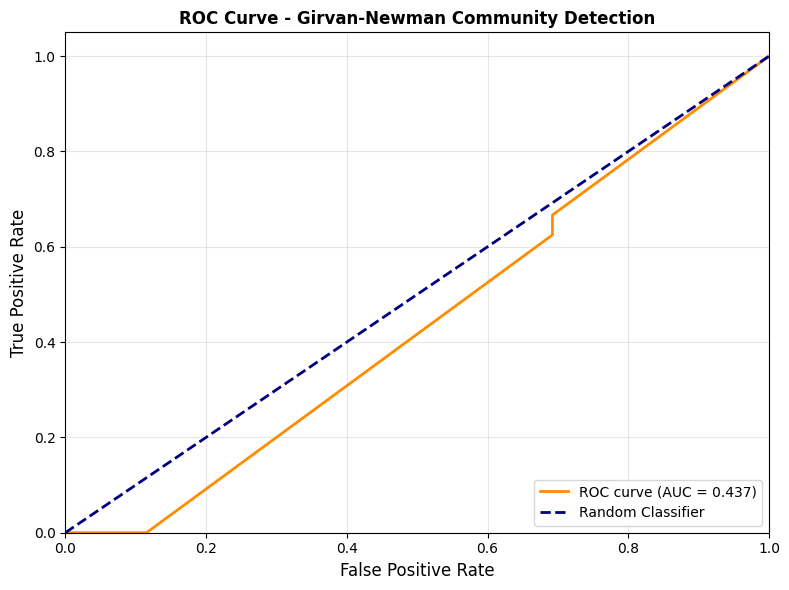

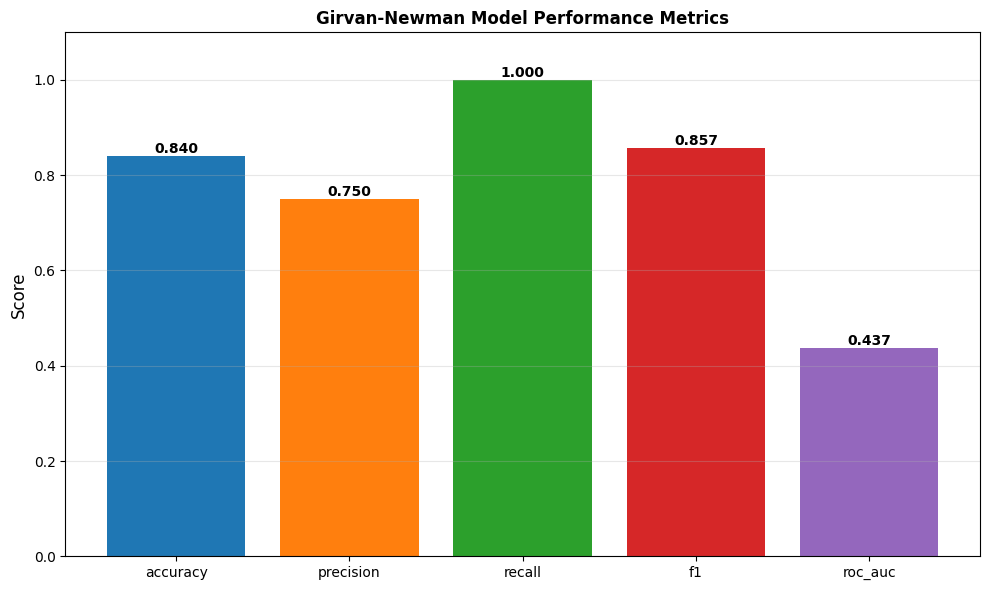

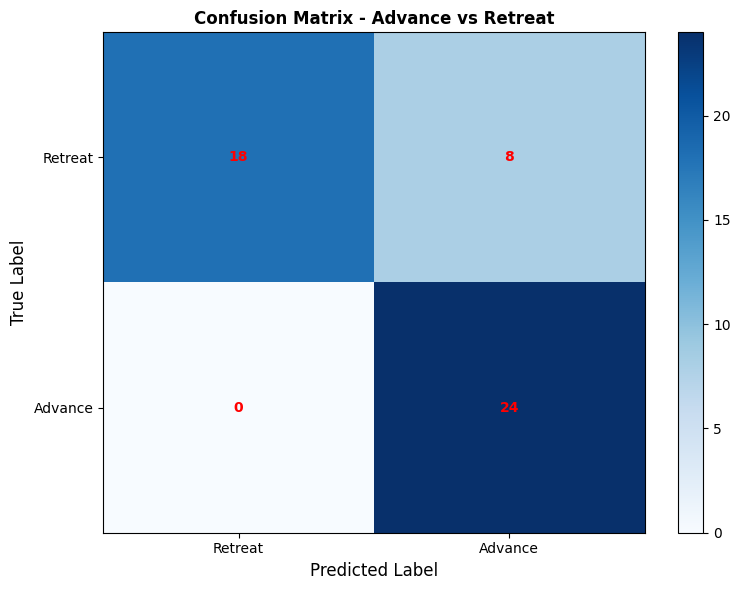

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkx.algorithms import community
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, auc, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')


def minard_graph():
    data1 = """\
24.0,54.9,340000,A,1
24.5,55.0,340000,A,1
25.5,54.5,340000,A,1
26.0,54.7,320000,A,1
27.0,54.8,300000,A,1
28.0,54.9,280000,A,1
28.5,55.0,240000,A,1
29.0,55.1,210000,A,1
30.0,55.2,180000,A,1
30.3,55.3,175000,A,1
32.0,54.8,145000,A,1
33.2,54.9,140000,A,1
34.4,55.5,127100,A,1
35.5,55.4,100000,A,1
36.0,55.5,100000,A,1
37.6,55.8,100000,A,1
37.7,55.7,100000,R,1
37.5,55.7,98000,R,1
37.0,55.0,97000,R,1
36.8,55.0,96000,R,1
35.4,55.3,87000,R,1
34.3,55.2,55000,R,1
33.3,54.8,37000,R,1
32.0,54.6,24000,R,1
30.4,54.4,20000,R,1
29.2,54.3,20000,R,1
28.5,54.2,20000,R,1
28.3,54.3,20000,R,1
27.5,54.5,20000,R,1
26.8,54.3,12000,R,1
26.4,54.4,14000,R,1
25.0,54.4,8000,R,1
24.4,54.4,4000,R,1
24.2,54.4,4000,R,1
24.1,54.4,4000,R,1"""
    data2 = """\
24.0,55.1,60000,A,2
24.5,55.2,60000,A,2
25.5,54.7,60000,A,2
26.6,55.7,40000,A,2
27.4,55.6,33000,A,2
28.7,55.5,33000,R,2
29.2,54.2,30000,R,2
28.5,54.1,30000,R,2
28.3,54.2,28000,R,2"""
    data3 = """\
24.0,55.2,22000,A,3
24.5,55.3,22000,A,3
24.6,55.8,6000,A,3
24.6,55.8,6000,R,3
24.2,54.4,6000,R,3
24.1,54.4,6000,R,3"""
    cities = """\
24.0,55.0,Kowno
25.3,54.7,Wilna
26.4,54.4,Smorgoni
26.8,54.3,Moiodexno
27.7,55.2,Gloubokoe
27.6,53.9,Minsk
28.5,54.3,Studienska
28.7,55.5,Polotzk
29.2,54.4,Bobr
30.2,55.3,Witebsk
30.4,54.5,Orscha
30.4,53.9,Mohilow
32.0,54.8,Smolensk
33.2,54.9,Dorogobouge
34.3,55.2,Wixma
34.4,55.5,Chjat
36.0,55.5,Mojaisk
37.6,55.8,Moscou
36.6,55.3,Tarantino
36.5,55.0,Malo-Jarosewii"""

    c = {}
    for line in cities.split("\n"):
        x, y, name = line.split(",")
        c[name] = (float(x), float(y))

    g = []

    for data in [data1, data2, data3]:
        G = nx.Graph()
        i = 0
        G.pos = {}
        G.pop = {}
        G.direction = {}
        last = None
        for line in data.split("\n"):
            x, y, p, r, n = line.split(",")
            G.pos[i] = (float(x), float(y))
            G.pop[i] = int(p)
            G.direction[i] = 1 if r == 'A' else 0
            if last is None:
                last = i
            else:
                G.add_edge(i, last, weight=int(p))
                last = i
            i = i + 1
        g.append(G)

    return g, c


def create_unified_graph(g):
    """Create a single unified graph from all army data."""
    G_combined = nx.Graph()
    node_offset = 0
    
    for army_idx, G in enumerate(g):
        for node in G.nodes():
            new_node_id = node_offset + node
            G_combined.add_node(new_node_id)
            G_combined.nodes[new_node_id]['direction'] = G.direction[node]
            G_combined.nodes[new_node_id]['pos'] = G.pos[node]
            G_combined.nodes[new_node_id]['pop'] = G.pop[node]
            
        for edge in G.edges(data=True):
            u, v = edge[0], edge[1]
            G_combined.add_edge(node_offset + u, node_offset + v, weight=edge[2]['weight'])
        
        node_offset += len(G.nodes()) + 100
    
    return G_combined


def girvan_newman_communities(G, num_communities=2):
    """Apply Girvan-Newman algorithm for community detection."""
    G_copy = G.copy()
    dendrogram = community.girvan_newman(G_copy)
    
    for _ in range(num_communities - 1):
        next(dendrogram)
    
    return list(next(dendrogram))


def calculate_modularity(G, communities_list):
    """Calculate modularity for a community partition."""
    return nx.community.modularity(G, communities_list)


def generate_predictions_from_communities(G, communities):
    """Generate predictions based on Girvan-Newman communities."""
    nodes = sorted(G.nodes())
    y_true = np.array([G.nodes[node]['direction'] for node in nodes])
    y_pred = np.zeros(len(nodes), dtype=int)
    
    # Assign predictions based on majority direction in each community
    for comm in communities:
        comm_directions = [G.nodes[node]['direction'] for node in comm if node in G.nodes()]
        if len(comm_directions) > 0:
            majority_direction = 1 if np.mean(comm_directions) >= 0.5 else 0
            for node in comm:
                if node in G.nodes():
                    y_pred[nodes.index(node)] = majority_direction
    
    # Generate probability scores based on betweenness centrality
    betweenness = nx.betweenness_centrality(G, weight='weight')
    y_proba = np.array([betweenness[node] for node in nodes])
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-10)
    
    return y_true, y_pred, y_proba


def calculate_metrics(y_true, y_pred, y_proba):
    """Calculate all performance metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(y_true, y_proba)
    except:
        roc_auc = 0.5
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }


def plot_minard_graph(g, city):
    """Plot the Minard visualization."""
    plt.figure(figsize=(11, 5))
    colors = ["b", "g", "r"]
    
    for G in g:
        c = colors.pop(0)
        node_size = [G.pop[n] // 300 for n in G]
        nx.draw_networkx_edges(G, G.pos, edge_color=c, width=4, alpha=0.5)
        nx.draw_networkx_nodes(G, G.pos, node_size=node_size, node_color=c, alpha=0.5)
        nx.draw_networkx_nodes(G, G.pos, node_size=5, node_color="k")

    for c in city:
        x, y = city[c]
        plt.text(x, y + 0.1, c, fontsize=8)
    
    plt.title("Minard's Visualization of Napoleon's 1812 Campaign")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_proba):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Girvan-Newman Community Detection', fontsize=12, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_metrics(metrics):
    """Plot performance metrics as bar chart."""
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metric_names, metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.ylim([0, 1.1])
    plt.ylabel('Score', fontsize=12)
    plt.title('Girvan-Newman Model Performance Metrics', fontsize=12, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues', aspect='auto')
    plt.colorbar()
    
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix - Advance vs Retreat', fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red', fontweight='bold')
    
    plt.xticks([0, 1], ['Retreat', 'Advance'])
    plt.yticks([0, 1], ['Retreat', 'Advance'])
    plt.tight_layout()
    plt.show()


# ============================================================================ #
# Main execution
# ============================================================================ #
if __name__ == "__main__":
    print("=" * 80)
    print("Minard Dataset Analysis with Girvan-Newman Community Detection")
    print("=" * 80)
    
    # Load data
    g, city = minard_graph()
    
    # Create unified graph
    G_combined = create_unified_graph(g)
    
    print(f"\nUnified Graph Statistics:")
    print(f"  Total nodes: {G_combined.number_of_nodes()}")
    print(f"  Total edges: {G_combined.number_of_edges()}")
    print(f"  Network density: {nx.density(G_combined):.4f}")
    
    # Extract true labels
    nodes = sorted(G_combined.nodes())
    y_true = np.array([G_combined.nodes[node]['direction'] for node in nodes])
    
    print(f"\nLabel Distribution:")
    print(f"  Advance (1): {np.sum(y_true)} nodes ({np.sum(y_true)/len(y_true)*100:.1f}%)")
    print(f"  Retreat (0): {len(y_true) - np.sum(y_true)} nodes ({(1-np.sum(y_true)/len(y_true))*100:.1f}%)")
    
    # Apply Girvan-Newman for 2 communities
    print(f"\nApplying Girvan-Newman Algorithm...")
    communities = girvan_newman_communities(G_combined, num_communities=2)
    modularity = calculate_modularity(G_combined, communities)
    
    print(f"  Communities found: {len(communities)}")
    print(f"  Community sizes: {sorted([len(c) for c in communities], reverse=True)}")
    print(f"  Modularity: {modularity:.4f}")
    
    # Assign community labels and save to GEXF
    for idx, comm in enumerate(communities):
        for node in comm:
            G_combined.nodes[node]['community'] = idx

    output_file = "minard_girvan_newman.gexf"
    # Convert unsupported attribute types (e.g., tuple -> string) for GEXF export
for n, data in G_combined.nodes(data=True):
    for k, v in list(data.items()):
        if isinstance(v, tuple):
            # Convert tuple (e.g., position) to a comma-separated string
            G_combined.nodes[n][k] = ','.join(map(str, v))

output_file = "minard_girvan_newman.gexf"
nx.write_gexf(G_combined, output_file)
print(f"\n✅ Graph exported to '{output_file}' successfully!")

nx.write_gexf(G_combined, output_file)
print(f"\n✅ Graph exported to '{output_file}' successfully!")
    
    # Generate predictions
y_true, y_pred, y_proba = generate_predictions_from_communities(G_combined, communities)
    
    # Calculate metrics
metrics = calculate_metrics(y_true, y_pred, y_proba)
    
print("\n" + "=" * 80)
print("Performance Metrics (Girvan-Newman Communities):")
print("=" * 80)
print(f"  Accuracy:  {metrics['accuracy']:.4f}")
print(f"  Precision: {metrics['precision']:.4f}")
print(f"  Recall:    {metrics['recall']:.4f}")
print(f"  F1 Score:  {metrics['f1']:.4f}")
print(f"  AUC-ROC:   {metrics['roc_auc']:.4f}")
print("=" * 80)
    
    # Visualizations
print("\nGenerating visualizations...")
plot_minard_graph(g, city)
plot_roc_curve(y_true, y_proba)
plot_metrics(metrics)
plot_confusion_matrix(y_true, y_pred)
